In [30]:
import numpy as np
import json
from sklearn.model_selection import train_test_split

def preprocess_5x5_data(data):
    X = []
    y = []
    
    for puzzle in data:
        combined = np.array(puzzle['combined']).reshape(10, 5)
        combined = combined / np.max(combined)
        X.append(combined)
        y.append(np.array(puzzle['solution']).reshape(5, 5))
    
    return np.array(X), np.array(y)

def preprocess_10x10_data(data):
    X = []
    y = []
    
    for puzzle in data:
        combined = np.array(puzzle['combined']).reshape(20, 10)
        combined = combined / np.max(combined)
        X.append(combined)
        y.append(np.array(puzzle['solution']).reshape(10, 10))
    
    return np.array(X), np.array(y)

def load_and_preprocess_data(size='5x5'):
    with open(f'data/{size}.json', 'r') as f:
        data = json.load(f)
    if size == '5x5':
        X, y = preprocess_5x5_data(data)
    elif size == '10x10':
        X, y = preprocess_10x10_data(data)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_val, y_train, y_val

if __name__ == "__main__":
    X_train, X_val, y_train, y_val = load_and_preprocess_data()
    print(f"Training samples: {len(X_train)}")
    print(f"Validation samples: {len(X_val)}")

Training samples: 72
Validation samples: 18


In [31]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Reshape, Dropout, MaxPooling2D
from tensorflow.keras.regularizers import l2

def create_5x5_nonogram_cnn():
    inputs = Input(shape=(10, 5, 1))  # 10 rows of tips (5 for rows, 5 for columns), 5 columns (max 2 tips per row/column)
    
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(25, activation='sigmoid')(x)  # 5x5 = 25 output neurons
    
    outputs = Reshape((5, 5))(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

def create_10x10_nonogram_cnn():
    inputs = Input(shape=(20, 10, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dense(100, activation='sigmoid')(x)

    outputs = Reshape((10, 10))(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model



GPU is available. Found 1 GPU(s):
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU available: True
Epoch 1/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 259ms/step - accuracy: 0.0851 - loss: 2.3549 - val_accuracy: 0.0452 - val_loss: 2.1663
Epoch 2/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0426 - loss: 2.1174 - val_accuracy: 0.0452 - val_loss: 1.9358
Epoch 3/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0511 - loss: 1.8958 - val_accuracy: 0.0286 - val_loss: 1.7328
Epoch 4/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0425 - loss: 1.7030 - val_accuracy: 0.0190 - val_loss: 1.5641
Epoch 5/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0293 - loss: 1.5411 - val_accuracy: 0.0190 - val_loss: 1.4219
Epoch 6/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0348 - loss: 1.3988 - val_accuracy: 0.0190 - val_loss: 1.2969
Epoch 7/3000
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0411 - loss: 1.2807 - val_accuracy: 0.0214 - val_loss: 1.

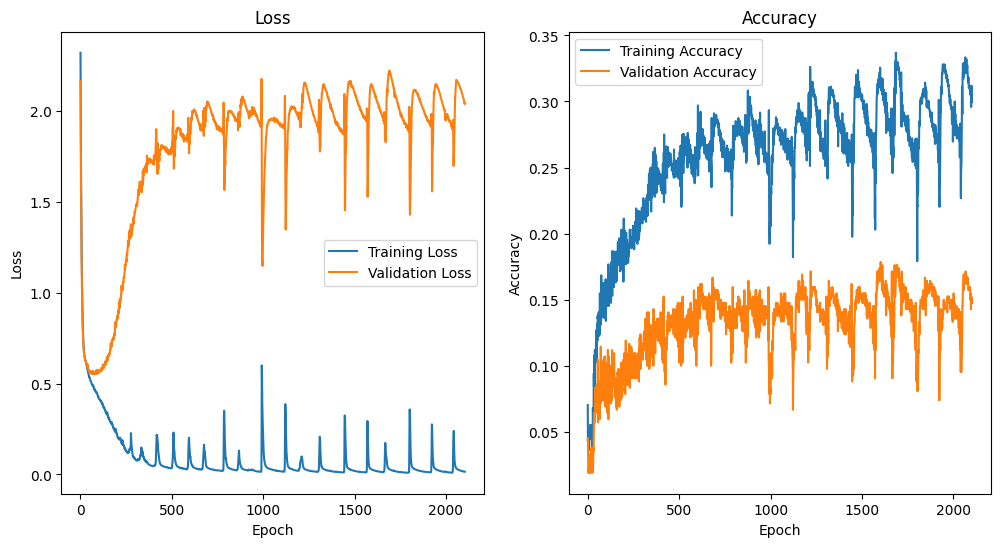

Validation accuracy: 0.1786
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step


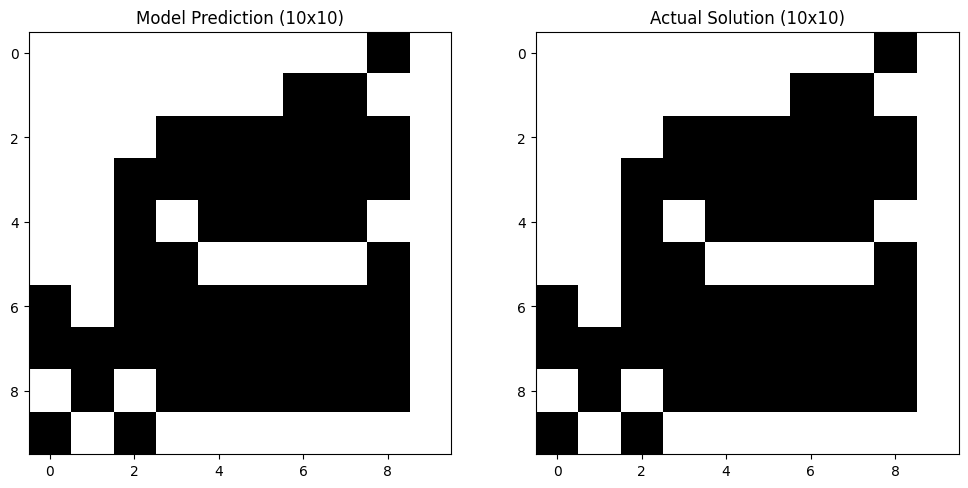

Puzzle solving accuracy: 1.00


In [32]:
import tensorflow as tf
import numpy as np
import json
import time
import random
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def check_gpu():
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print(f"GPU is available. Found {len(gpus)} GPU(s):")
        for gpu in gpus:
            print(f"  {gpu}")
    else:
        print("No GPU found. Training will proceed on CPU.")
    return bool(gpus)

def test_model_on_puzzle(model, puzzle_data, size='5x5'):
    if size == '5x5':
        # Preprocess the 5x5 puzzle data
        combined = np.array(puzzle_data['combined']).reshape(10, 5)  # Adjust if needed based on actual data format
        combined = combined / np.max(combined)
        X = combined[np.newaxis, :, :, np.newaxis]
        
        # Make prediction
        prediction = model.predict(X)[0]
        prediction = (prediction > 0.5).astype(int)
        
        # Get actual solution
        solution = np.array(puzzle_data['solution']).reshape(5, 5)
    
    elif size == '10x10':
        # Preprocess the 10x10 puzzle data
        combined = np.array(puzzle_data['combined']).reshape(20, 10)  # Adjust if needed based on actual data format
        combined = combined / np.max(combined)
        X = combined[np.newaxis, :, :, np.newaxis]
        
        # Make prediction
        prediction = model.predict(X)[0]
        prediction = (prediction > 0.5).astype(int)
        
        # Get actual solution
        solution = np.array(puzzle_data['solution']).reshape(10, 10)
    
    else:
        raise ValueError("Unsupported nonogram size. Please use '5x5' or '10x10'.")
    
    # Visualize
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    
    ax1.imshow(prediction, cmap='binary')
    ax1.set_title(f'Model Prediction ({size})')
    
    ax2.imshow(solution, cmap='binary')
    ax2.set_title(f'Actual Solution ({size})')
    
    plt.show()
    
    # Compute and print accuracy
    accuracy = np.mean(prediction == solution)
    print(f"Puzzle solving accuracy: {accuracy:.2f}")

def pick_random_puzzle(size='5x5'):
    with open(f'data/{size}.json', 'r') as file:
        random.seed(time.time())
        file_data = json.load(file)
        puzzle = random.choice(file_data)
        return puzzle

def plot_learning_curves(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def main():
    # Check GPU availability
    gpu_available = check_gpu()
    size = "10x10"
    print(f"GPU available: {gpu_available}")

    # Load and preprocess data
    X_train, X_val, y_train, y_val = load_and_preprocess_data(size)

    # Create and compile the model
    if size == '5x5':
        model = create_5x5_nonogram_cnn()
    elif size == '10x10':
        model = create_10x10_nonogram_cnn()
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=500, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(f'{size}_best_model.keras', monitor='val_accuracy', save_best_only=True)

    # Train the model
    with tf.device('/GPU:0' if gpu_available else '/CPU:0'):
        history = model.fit(X_train, y_train,
                            batch_size=32,
                            epochs=3000,
                            validation_data=(X_val, y_val),
                            verbose=1,
                            callbacks=[early_stopping])

    # Load the best model (if checkpointing)

    plot_learning_curves(history)

    # Evaluate the model
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    print(f"Validation accuracy: {val_accuracy:.4f}")
    
    test_model_on_puzzle(model, pick_random_puzzle(size), size)

    # Optionally, save the model
    model.save(f'{size}_nonogram_model.keras')

if __name__ == "__main__":
    main()